## OMP(Orthgonal match pursuit) ##

In [1]:
import numpy as np
from sklearn import linear_model,datasets #此处引用sklearn只是为了使用数据集，以及测试，在程序中并没有用到框架
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
def omp(y,dictionary,sparsity=1):
    """
    orthogonal match pursuit
    参数
    ------
    y: 原样本
    dictionary: 字典
    sparsity: 稀疏度

    返回值
    -------
    sparsecode：稀疏矩阵
    """
    sparsecode = np.zeros([dictionary.shape[1],y.shape[1]])
    for i in range(y.shape[1]):
        res = y[:,i]
        for n in range(sparsity):
            maxindex = (np.abs(res.dot(dictionary))).argmax()
            a = np.linalg.pinv(dictionary[:,maxindex].reshape(25, 1))
            sparsecode[maxindex,i] = np.dot(a,y[:,i])
            res = y[:,i] - dictionary.dot(sparsecode[:,i])
    return sparsecode

In [3]:
def orth(data):
    """
    schmidt orthogonalization
    参数
    ------
    data: 输入矩阵

    返回值
    -------
    b：正交矩阵
    """
    b = np.zeros_like(data)
    for i in range(data.shape[0]):
        b[i,:] = data[i,:]
        for j in range(i):
            b[i,:] -= (np.dot(data[i,:],b[j,:])/np.dot(b[j,:],b[j,:]))*b[j,:]
    for i in range(b.shape[0]):
        b[i] /= (b[i].dot(b[i]))**0.5
    return b

## K-SVD ##
主要参考K-SVD: An Algorithm for Designing Overcomplete Dictionaries for Sparse Representation<br/>
(http://sites.fas.harvard.edu/~cs278/papers/ksvd.pdf)

In [4]:
class KSVD(object):
    
    """
    k-svd
    参考
    ------
    K-SVD: An Algorithm for Designing Overcomplete Dictionaries for Sparse Representation
    (http://sites.fas.harvard.edu/~cs278/papers/ksvd.pdf)
    
    参数
    ------
    max_iter: 最大迭代次数
    tol: 最大容忍误差
    components: 字典原子个数
    data: 数据
    features: 特征数量
    samples: 样本数量
    dictionary: 字典
    sparsecode: 稀疏编码
    class_mean: 各类别的均值
    nonzero_coefs: 非零参数个数(稀疏度)
    返回值
    -------
    dictionary: 字典矩阵
    sparsecode：稀疏编码矩阵
    """
    def __init__(self,components,data,max_iter=30,tol=1e-6,nonzero_coefs=1):
        self.max_iter = max_iter                                                     #最大迭代次数
        self.tol = tol                                                               #最大误差
        self.components = components                                                 #字典原子个数
        self.data = data                                                             #数据
        self.features = self.data.shape[0]                                           #特征个数
        self.samples = self.data.shape[1]                                            #样本个数
        self.dictionary = np.zeros([self.features,self.components])                  #字典
        self.sparsecode = np.zeros([self.components,self.samples])                   #稀疏编码
        self.nonzero_coefs = nonzero_coefs                                           #稀疏度

    """
    初始化字典以及系数编码
    构造欠完备字典时可以取数据左奇异矩阵构造，这样字典本身就是正交的，使用mp算法就可以达到omp的效果
    构造过完备矩阵时取多列数据构造字典
    """ 
    def _initialize(self):
        # u, s, v = np.linalg.svd(self.data)
        # self.dictionary = u[:, :self.components]
        self.dictionary = self.data[:, :self.components]
        self.dictionary = orth(self.dictionary)
        self.sparsecode = omp(self.data,self.dictionary,self.nonzero_coefs)
        # self.sparsecode = linear_model.orthogonal_mp(self.dictionary, self.data, n_nonzero_coefs=self.nonzero_coefs)
    
    """
    更新字典
    在ksvd算法中每次迭代同时更新了字典和稀疏编码
    每次迭代中按顺序更新一列字典和一行稀疏编码矩阵
    具体解释见K-SVD: An Algorithm for Designing Overcomplete Dictionaries for Sparse Representation
    """
    def _update_dict(self):
        for i in range(self.components):
            index = np.nonzero(self.sparsecode[i, :])[0]#与当前字典列有关的项
            if len(index) == 0:
                continue

            self.dictionary[:, i] = 0
            self.sparsecode[i,:] = 0
            r = (self.data - np.dot(self.dictionary,self.sparsecode))[:, index]
            #去除当前字典列和稀疏矩阵行并去除了与当前字典列有关的项的反算数据
            u, s, v = np.linalg.svd(r, full_matrices=False)
            self.dictionary[:, i] = u[:, 0].T
            self.sparsecode[i, index] = s[0] * v[0, :]
    """
    迭代过程：更新字典，通过omp计算稀疏矩阵
    """
    def _iteration(self):
        self._update_dict()
        #self.sparsecode = linear_model.orthogonal_mp(self.dictionary, self.data, n_nonzero_coefs=self.nonzero_coefs)
        self.sparsecode = omp(self.data,self.dictionary,self.nonzero_coefs)
        
    """
    开始迭代，当容差达到要求或达到最大迭代次数时停止迭代
    """
    def run(self):
        self._initialize()
        for i in range(self.max_iter):
            self._iteration()
            e = np.linalg.norm(self.data - np.dot(self.dictionary, self.sparsecode))
            if e < self.tol:
                break
        return self.dictionary, self.sparsecode

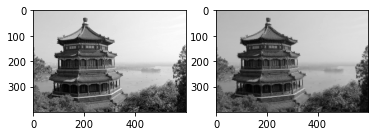

In [5]:
china_img = datasets.load_sample_image('china.jpg')
china_img = (0.2989 * china_img[:,:,0] + 0.5870 * china_img[:,:,1] + 0.1140 * china_img[:,:,2]).astype(int)
china_img = china_img[:400,:600]

#将图像5*5的小块设置为一个样本
n = 0
china_reimg = np.zeros([25,9600])
for r in range(80):
    for c in range(120):
        china_reimg[:,n] = china_img[5*r:5*r+5,5*c:5*c+5].flatten()
        n+=1

#ksvd
ksvd = KSVD(50,china_reimg)
dictionary, sparsecode = ksvd.run()
#反算数据
x = dictionary.dot(sparsecode)

#还原图像
n=0
china_reimg1 = np.zeros([400,600])
for r in range(80):
    for c in range(120):
        china_reimg1[5*r:5*r+5,5*c:5*c+5] = x[:,n].reshape([5,5])
        n+=1

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(china_img,'gray')
plt.subplot(1, 2, 2)
plt.imshow(china_reimg1,'gray')
plt.show()

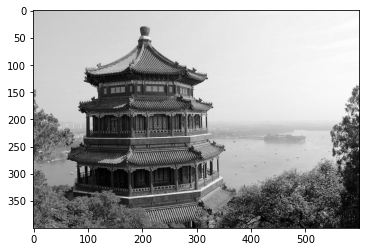

In [6]:
plt.imshow(china_img,'gray')

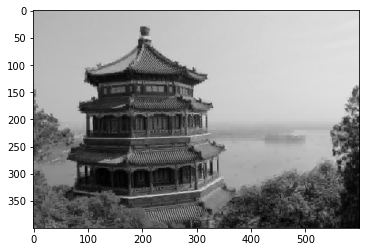

In [7]:
plt.imshow(china_reimg1,'gray')

## MOD(Method of optimal directions) ##
在相同迭代次数下，MOD的效果比KVSD差

In [8]:
class MOD(object):
    
    """
    Method of optimal directions
    参数
    ------
    max_iter: 最大迭代次数
    tol: 最大容忍误差
    components: 字典原子个数
    data: 数据
    features: 特征数量
    samples: 样本数量
    dictionary: 字典
    sparsecode: 稀疏编码
    class_mean: 各类别的均值
    nonzero_coefs: 非零参数个数(稀疏度)
    返回值
    -------
    dictionary: 字典矩阵
    sparsecode：稀疏编码矩阵
    """
    def __init__(self,components,data,max_iter=30,tol=1e-6,nonzero_coefs=None):
        self.max_iter = max_iter                                                     #最大迭代次数
        self.tol = tol                                                               #最大误差
        self.components = components                                                 #字典原子个数
        self.data = data                                                             #数据
        self.features = self.data.shape[0]                                           #特征个数
        self.samples = self.data.shape[1]                                            #样本个数
        self.dictionary = np.zeros([self.features,self.components])                  #字典
        self.sparsecode = np.zeros([self.components,self.samples])                   #稀疏编码
        self.nonzero_coefs = nonzero_coefs                                           #稀疏度

    """
    初始化字典以及系数编码
    """ 
    def _initialize(self):
        self.dictionary = self.data[:, :self.components]
        self.dictionary = orth(self.dictionary)
        self.sparsecode = omp(self.data,self.dictionary)
        # self.sparsecode = linear_model.orthogonal_mp(self.dictionary, self.data, n_nonzero_coefs=self.nonzero_coefs)
    
    """
    更新字典
    (Y-DX)X^T=0   ==>  D=YX^T(XX^T)^-1    
    """
    def _update_dict(self):            
        self.dictionary = self.data.dot(self.sparsecode.T.dot(np.linalg.pinv(np.dot(self.sparsecode,self.sparsecode.T))))
            
    """
    迭代过程：更新字典，通过omp计算稀疏矩阵
    """
    def _iteration(self):
        self._update_dict()
        #self.sparsecode = linear_model.orthogonal_mp(self.dictionary, self.data, n_nonzero_coefs=self.nonzero_coefs)
        self.sparsecode = omp(self.data,self.dictionary)
        
    """
    开始迭代，当容差达到要求或达到最大迭代次数时停止迭代
    """
    def run(self):
        self._initialize()
        for i in range(self.max_iter):
            self._iteration()
            e = np.linalg.norm(self.data - np.dot(self.dictionary, self.sparsecode))
            if e < self.tol:
                break
        return self.dictionary, self.sparsecode

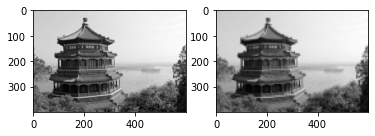

In [9]:
china_img = datasets.load_sample_image('china.jpg')
china_img = (0.2989 * china_img[:,:,0] + 0.5870 * china_img[:,:,1] + 0.1140 * china_img[:,:,2]).astype(int)
china_img = china_img[:400,:600]

#将图像5*5的小块设置为一个样本
n = 0
china_reimg = np.zeros([25,9600])
for r in range(80):
    for c in range(120):
        china_reimg[:,n] = china_img[5*r:5*r+5,5*c:5*c+5].flatten()
        n+=1

#ksvd
mod = MOD(50,china_reimg)
dictionary, sparsecode = mod.run()
#反算数据
x = dictionary.dot(sparsecode)

#还原图像
n=0
china_reimg1 = np.zeros([400,600])
for r in range(80):
    for c in range(120):
        china_reimg1[5*r:5*r+5,5*c:5*c+5] = x[:,n].reshape([5,5])
        n+=1

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(china_img,'gray')
plt.subplot(1, 2, 2)
plt.imshow(china_reimg1,'gray')
plt.show()

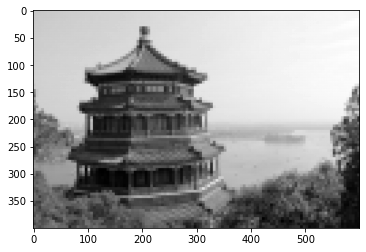

In [10]:
plt.imshow(china_reimg1,'gray')